# Derivatives 2020

#### Dr. Fabian Woebbeking | fabian.woebbeking@dozent.frankfurt-school.de


### Content

* [Symmetric derivatives](#SymmetricDerivatives)
* [Asymmetric derivatives](#AsymmetricDerivatives)
* [Credit derivatives](#CreditDerivatives)

## Put-Call-Parity
Put-Call-Parity is the arbitrage relationship between (European) put, call, and forward.

$$PV(Call) - PV(Put) = S_0 - PV(K)$$

With cash flows at maturity $T$:

$CF(T, Call) = max(S_T - K, 0) = (S_T - K)^+$

$CF(T, Put)  = max(K - S_T, 0) = (K - S_T)^+$

$CF(T, Fwd) = S_T - K$


For example, if a call option is overpriced w.r.t. its replicating portfolio, i.e. Fwd + Put, sell the call and buy the replication. The resulting shift in supply and demand must adjust prices.

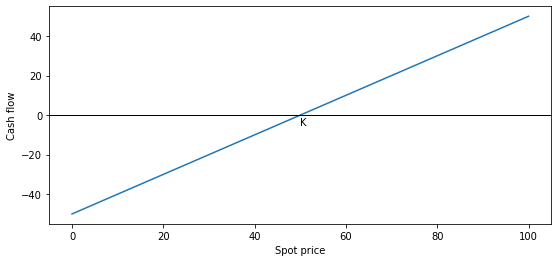

In [1]:
"""Spot price vs cash flow (put-call parity)
"""
import numpy as np
import matplotlib.pyplot as plt

# see workbook task 4 ff.
S_T = np.linspace(0,100)
K = 50

# portfolio
CF_T = np.maximum(S_T - K, 0) - np.maximum(K-S_T,0)

# the rest is plotting
plt.figure('PCP', figsize=(9,4))
plt.plot(S_T, CF_T)
plt.axhline(y=0, linewidth=1, color="black")
plt.xlabel("Spot price")
plt.ylabel("Cash flow")
plt.annotate("K", (K,-5))
plt.show()

<a id='SymmetricDerivatives'></a>
# Symmetric derivatives

## Interest rate languages

Interest rates are quoted per annum (p.a.) but speak different “languages”:

Money Market (MM): 

$C_0(1+r_{mm}T)=C_T$

ISMA (International Securities Market Association - Europe)

$C_0(1+r_{isma})^T=C_T$

SIA (Securities Industry Association - US)

$C_0(1+r_{sia}/2)^{2T}=C_T$

Continous compounding (academics, financial engineering)

$C_0 e^{rT} = C_T$

T is calculated by dividing the number of days in perid T by a year basis, e.g.

$T = act/360$ (Money Markets - DE/US/...)

$T = act/act$ (Bond - ISMA)

$T = 30/360$ (Swap)

These are some examples for day count conventions, which might differ from country to country. Observe that for $act/act$ and $30/360$, a full year must always yield $T=1$.

In [2]:
"""Interest rate conversion (translation)
"""
import numpy as np

r_isma = 0.1
r_mm = (r_isma*360/365)
r_sia = ((1+r_isma)**0.5-1)*2
r_cont = np.log(1+r_isma)

print(f'r_isma  = {r_isma:.4f}')
print(f'r_mm    = {r_mm:.4f}')
print(f'r_sia   = {r_sia:.4f}')
print(f'r_cont  = {r_cont:.4f}')

r_isma  = 0.1000
r_mm    = 0.0986
r_sia   = 0.0976
r_cont  = 0.0953


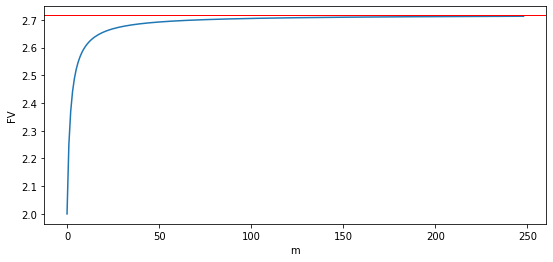

FV(m = 100000) = 2.7183
EXP(1)         = 2.7183


In [3]:
"""Continous compounding
"""
import numpy as np
import matplotlib.pyplot as plt

def FV(m):
    PV = 1
    r  = 1
    T  = 1
    return PV * (1 + r / m)**(T * m)

#FV_m = list(map(lambda m: FV(m), range(1,250)))
FV_m = FV(np.arange(1,250))

# plotting
plt.figure('exp', figsize=(9,4))
plt.plot(FV_m)
plt.axhline(y=np.exp(1), linewidth=1, color="red")
plt.xlabel("m")
plt.ylabel("FV")
plt.show()

print(f'FV(m = 100000) = {FV(100000):.4f}')
print(f'EXP(1)         = {np.exp(1):.4f}')

## Optimal hedge ratio

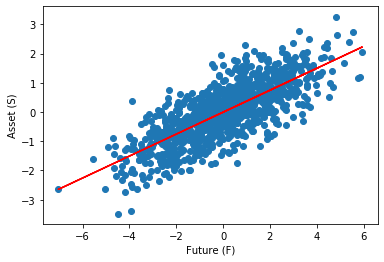

In [4]:
"""Optimal hedge ratio vs linear regression beta
"""
import numpy as np
from numpy.random import randn
from numpy.polynomial.polynomial import polyfit
from scipy.linalg import cholesky
import matplotlib.pyplot as plt

corr = np.array([[1,.75],[.75,1]])
F, S = np.dot(randn(1000,2), cholesky(corr)).T
F = F * 2  # Assume future is about twice as volatile as the asset
constant, beta = polyfit(F, S, 1)

plt.figure('mvhegde')
plt.xlabel('Future (F)')
plt.ylabel('Asset (S)')
plt.scatter(F, S)
plt.plot(F, constant + beta * F, 'r-')
plt.show()

Hedge ratio for hedging asset S with future F

$$Var = \sigma^2_S + h^2\sigma^2_F-2 h \rho \sigma_S \sigma_F$$

$$\frac{\delta Var}{\delta h} = 2 h \sigma^2_F - 2 \rho \sigma_S \sigma_F = 0$$

$$...$$

$$h = \rho \frac{\sigma_S}{\sigma_F}$$

In [5]:
rho = np.corrcoef(F,S)[0][1]
sd_F = np.std(F)
sd_S = np.std(S)

print(f"Linear regression beta: {beta:.4f}")
print(f"Optimal hedge ratio h : {(rho*sd_S/sd_F):.4f}")

Linear regression beta: 0.3756
Optimal hedge ratio h : 0.3756


## Coupon bonds

A discount factor is today's price for 1 monetary unit in t, hence, a zero bond with face value 1 and maturity t.

$$C_0 = C_t DF_t \implies DF_t = \frac{C_0}{C_t}$$

The discount factor does not speak a language! However, it can be translated into any interest rate language, e.g.

$$C_0 = C_t \frac{1}{(1 + r)^t} \implies DF_t = \frac{1}{(1+r)^t} \implies r = \left(\frac{1}{DF_t}\right)^{1/t} - 1$$

And as usual

$$PV = \sum^{T}_{t=1}\frac{C_t}{(1+r_t)^t} = \sum^{T}_{t=1}C_t DF_t$$

In [6]:
"""Discounting for plain vanilla coupon bonds
"""
discount_factors = [.9091, .8116, .7118]  # Slide 55

def fair_price(coupon):
    # sum(discount_factors) is an annuity factor
    # the last discount factor [-1] discounts the face value
    p = coupon * sum(discount_factors) + discount_factors[-1]  
    return p

print(f'Fair price  6% 3Y bond:  {fair_price(0.06)*100:.4f}')
print(f'Fair price 12% 3Y bond: {fair_price(0.12)*100:.4f}')

Fair price  6% 3Y bond:  85.7750
Fair price 12% 3Y bond: 100.3700


[0.09998900010999878, 0.11001534051800954, 0.11998964004232815]


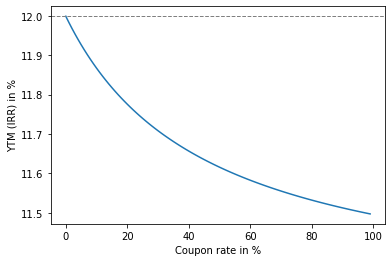

In [7]:
"""Coupon (nominal yield) vs yield to maturity
"""
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# see workbook task 17 ff.
#discount_factors = [.9524, .89, .8163]  # Task 17
discount_factors = [.9091, .8116, .7118]  # Slide 55 (normal term structure)
#discount_factors = [1/(1.12), 1/(1.10)**2, 1/(1.08)**3]  # inverted term structure


zero_rates = []
for T, DF_T in enumerate(discount_factors):
    T = T + 1
    r_T = (1 / DF_T) ** (1 / T) - 1
    zero_rates.append(r_T)
print(zero_rates)


# face value = 1!
def IRR(coupon, discount_factors):
    # calculate PV from market prices
    def fair_price(coupon):
        p = coupon * sum(discount_factors) + discount_factors[-1]
        return p
    # calculate PV from irr
    def IRR_price(irr, coupon):
        T = len(discount_factors)
        annuity_factor = (1 - (1 + irr) ** -T) / irr
        p = coupon * annuity_factor + 1 / (1 + irr) ** T
        return p
    # target function to be minimized
    def NPV2(irr):
        return (fair_price(coupon) - IRR_price(irr, coupon)) ** 2
    # set NPV = 0 and return both PVs and the irr
    opt = minimize(NPV2, x0=0.01, bounds = ((None, None),))
    return [fair_price(coupon), IRR_price(opt.x[0], coupon), opt.x[0]]


#print(IRR(.1, discount_factors))

# lets plot different coupon rates against irrs
x_coupons = range(100)
y_irrs = list(map(lambda c: IRR(c/100, discount_factors)[2]*100, x_coupons))

plt.plot(x_coupons, y_irrs)
plt.axhline(y=zero_rates[-1]*100, linestyle='--', linewidth=1, color='grey')
plt.xlabel("Coupon rate in %")
plt.ylabel("YTM (IRR) in %")
plt.show()

## Interest rate swaps

##### Discount factors and forward rates

Forward rate fixed in $s$ payed in $t$ has arbitrage condition

$$(1+r_s)^s(1+r_{st})^{t-s} = (1+r_t)^t$$

$$r_{st} = \left(\frac{(1+r_t)^t}{(1+r_s)^s}\right)^{1/(t-s)}-1 = \left(\frac{DF_s}{DF_t}\right)^{1/(t-s)}-1$$



##### Plain vanilla swap pricing

Agreement to exchange a fixed ($C$) against a variable ($L_t$) payment, assuming annual payments 

$$\begin{aligned}
PV(Fix) &= C \sum_{t=1}^T DF_t\\
PV(Var) &= \sum_{t=1}^T L_t DF_t\\
        &= \sum_{t=1}^T \left(\frac{DF_{t-1}}{DF_t} -1  \right) DF_t\\
        &= 1 - DF_t
\end{aligned}$$

Price the fair swap rate $C$ such that,

$$\begin{aligned}
PV(Fix) &= PV(Var)\\
C \sum_{t=1}^T DF_t &= 1 - DF_t\\
C        &= \frac{1 - DF_T}{\sum_{t=1}^T DF_t}
\end{aligned}$$



Mark to market an existing swap with $C^*$ (the old swap rate) by comparing $PV(Fix)$ and $PV(Var)$

$$\begin{aligned}
PV(Receiver) &= PV(Fix) - PV(Var)\\
    &= C^* \sum_{t=1}^T DF_t - (1 - DF_t) \\
    &= (C^* - C) \sum_{t=1}^T DF_t
\end{aligned}$$

Swap rate $C$ is also the par coupon bond rate that fulfills

$$\begin{aligned}
1 &= \sum^{T}_{t=1}C_t DF_t\\
    &= C \sum^{T}_{t=1}DF_t + DF_T \implies C   = \frac{1 - DF_T}{\sum^{T}_{t=1}DF_t}
\end{aligned}$$

#### Single curve approach

Uso one curve to
1. calculate (bootstrap) spot rates (discount factors)
2. calculate forward rates (substitute $L_t$ as cash flow)
3. solve for $C$ such that $PV(Fix)$ and $PV(Var)$

Bootstrapping, i.e. creating zero bonds from a market of coupon bearing instruments

$$DF_t = \frac{1 - C_t \sum_{i=1}^{t-1} DF_i}{1 + C_t}$$

In [8]:
"""Bootstrapping from swap rates (assuming annual payments)
"""
def swap_bootstrap(swap_rates):
    discount_factors = []
    for s in swap_rates:
        # See Slide 61 
        DF_T = (1 - s * sum(discount_factors)) / (1 + s)
        discount_factors.append(DF_T)
        
    zero_rates = []
    for T, DF_T in enumerate(discount_factors):
        # Python starts counting at 0, hence, +1
        T = T + 1
        # See Slide 48
        r_T = (1 / DF_T)**(1 / T) - 1
        zero_rates.append(round(r_T,4))
        
    return [discount_factors, zero_rates]

example = swap_bootstrap([0.04, 0.05, 0.06])
print(example)

[[0.9615384615384615, 0.9065934065934065, 0.8376529131246111], [0.04, 0.0503, 0.0608]]


In [9]:
"""Single curve swap pricing
"""
discount_factors = swap_bootstrap([0.04, 0.05, 0.06])[0]

def swap_pricing(discount_factors):
    # See Slide 66
    s_T = (1 - discount_factors[-1]) / sum(discount_factors)
    return s_T
    
print(f"3Y swap rate = {swap_pricing(discount_factors)*100:.2f}%")

3Y swap rate = 6.00%


In [10]:
"""Single curve forward swap pricing
"""
discount_factors = swap_bootstrap([0.04, 0.05, 0.06])[0]

# Calculate the 1 for 2 swap rate
s_13 = (discount_factors[0] - discount_factors[-1]) / sum(discount_factors[1::])

print(f"1X2 swap rate = {s_13*100:.2f}%")

1X2 swap rate = 7.10%


### Multi curve approach

#### Swap market after the financial crisis
* Credit risk in the Euribor fixings increased (basis)
* Credit risk is smaller for a shorter tenure (e.g. EONIA)
* Credit Support Annex (CSA) was introduced, all Swaps among financial institutions are collateralized.
* The credit risk in such a swap is very small (over night), but the fixings on the Euribor include credit risk.

#### Single curve
* The dicsount factors and the forwards are calculated individually for each product
* This gives correct results for pricing swaps with a ${NPV}=0$
* But using different discount curves leads to arbitrage and incorrect close out prices 

#### Multi curve (implied forwards)
* The dicsount factors are calculated from the swap curve closest to risk free, e.g. against EONIA
* For each different tenure the forwards are calibrated using the swap quotation and the EONIA discount factors
* Main advantage is the single discounting curve

Implied forward ($\tilde{L_T}$):
$$\tilde{L_T} = \frac{C_T \sum_{t=1}^T DF_t - \sum_{t=1}^{T-1} L_t DF_t}{DF_T} \equiv \frac{CD - LD}{DF_T}$$

In [11]:
"""Calculate implied forward rates (multi curve approach)
"""
def multi_curve(swap_rates, eonia_rates):
    # bootstrap discount factors from eonia rates
    discount_factors = swap_bootstrap(eonia_rates)[0]
    # setup 
    SDF = 0 # sum of discount factors
    CD = 0  # discounted fixed leg until T
    LD = 0  # discounted float leg until T-1
    
    implied_forwards = []
    for C_T, DF_T in zip(swap_rates, discount_factors):
        SDF += DF_T  # add up discount factors
        CD = C_T * SDF  # C_T is an annuity
        L = (CD - LD) / DF_T  # calculate implied forward rate (see equation above)
        implied_forwards.append(round(L,4))  # round and save L
        LD += L * DF_T  # sum up discounted L (used in next iteration)
        
    return implied_forwards
    
print(f"Implied forward rates: {multi_curve([0.04, 0.05, 0.06], [0.033, 0.045, 0.053])}")

Implied forward rates: [0.04, 0.0606, 0.082]


In [12]:
"""Price a forward swap (multi curve approach)
"""
implied_forwards = multi_curve([0.04, 0.05, 0.06], [0.033, 0.045, 0.053])
eonia_discount_factors = swap_bootstrap([0.033, 0.045, 0.053])[0]

PV_Var = sum(np.array(implied_forwards[1::]) * np.array(eonia_discount_factors[1::]))

s_13m = PV_Var / sum(eonia_discount_factors[1::])

print(f"1X2 swap rate (multi curve) = {s_13m*100:.2f}%")

1X2 swap rate (multi curve) = 7.09%


<a id='AsymmetricDerivatives'></a>
# Asymmetric derivatives

## Assumptions
* No transaction costs
* Same tax for all profits
* Borrowing and lending at the same risk-free rate $r_f$


## Option price boundaries

Notation:
* Stock price $S$
* Strike price $K$ (or $X$ in some text books)
* American call $C$ and put $P$
* European call $c$ and put $p$
* Time to maturity $T$


|               | Lower boundaries   &nbsp;  &nbsp;  &nbsp;  | Upper boundaries       |
|---------------|-------------------------------|--------------------|
| European Call | $c \ge S-K e^{-rT}$    | $c \le S$                |
| American Call |$C \ge S-Ke^{-rT}$      | $C \le S$                |
| European Put  | $p \ge K e^{-rT} - S$  | $p \le K e^{-rT}$         |
| American Put  | $P \ge K - S$          | $P \le K$                 |



Why it makes no sense to execute an american call option prematurely:
* A at 0: $C + Ke^{-rT}$ becomes at T: $\max(S_T,K)$
* B at 0: $S_0$ becomes at T: $S_T$
* exercise A at $\tau < T$ becmes: $S_\tau-K+Ke^{-r(T-\tau)}<S_\tau$
* Hence, never execute early, i.e. $C = c \ge S-Ke^{-rT}$
* Sell the option instead!


## Probability distributions

Consider random variable $X \sim \mathcal{N}(\mu,\sigma^2)$ as an example for an absolutely continuous univariate distribution.

Probability density function (PDF):
$$\phi(x) = \frac{d\Phi(x)}{dx} = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2} \left( \frac{x-\mu}{\sigma} \right)^2 }$$


Cumulative distribution function (CDF):
$$\Phi(x) = P(X \le x) = \int_{-\infty}^x \phi(u)\; du$$

Quantile function, i.e. inverse of the CDF:
$$\Phi^{-1}(p) = \inf \{x \in \mathbb{R}: p \le \Phi(x)\},\;\; p \in (0,1)$$

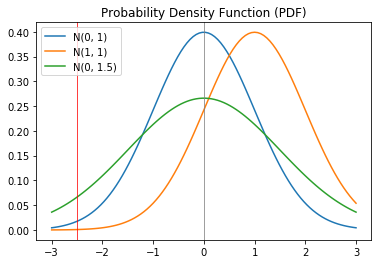

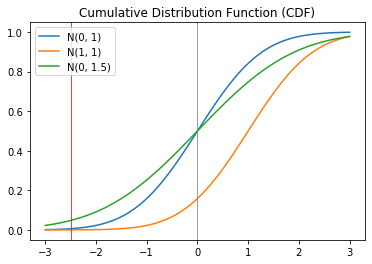

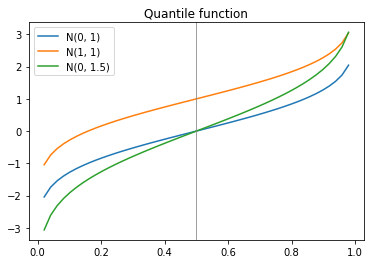

In [13]:
"""PDF vs CDF
"""
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

x = np.linspace(-3, 3, 100)
p = np.linspace(0, 1)

plt.figure("pdf")
plt.title("Probability Density Function (PDF)")
plt.plot(x, norm.pdf(x, 0, 1))
plt.plot(x, norm.pdf(x, 1, 1))
plt.plot(x, norm.pdf(x, 0, 1.5))
plt.axvline(x=-2.5, color='red', linewidth=.75)
plt.axvline(x=0, color='grey', linewidth=.75)
plt.legend(["N(0, 1)", "N(1, 1)", "N(0, 1.5)"], loc='upper left')

plt.figure("cdf")
plt.title("Cumulative Distribution Function (CDF)")
plt.plot(x, norm.cdf(x, 0, 1))
plt.plot(x, norm.cdf(x, 1, 1))
plt.plot(x, norm.cdf(x, 0, 1.5))
plt.axvline(x=-2.5, color='red', linewidth=.75)
plt.axvline(x=0, color='grey', linewidth=.75)
plt.legend(["N(0, 1)", "N(1, 1)", "N(0, 1.5)"], loc='upper left')

plt.figure("qf")
plt.title("Quantile function")
plt.plot(p, norm.ppf(p, 0, 1))
plt.plot(p, norm.ppf(p, 1, 1))
plt.plot(p, norm.ppf(p, 0, 1.5))
plt.axvline(x=0.5, color='grey', linewidth=.75)
plt.legend(["N(0, 1)", "N(1, 1)", "N(0, 1.5)"], loc='upper left')


plt.show()

## Stochastic processes

### Generalized Wiener process
A stochastic process $X$, with drift $\mu$ and dispersion $\sigma$, follows a generalized Wiener process if it satisfies the following stochastic differential equation (SDE)

$$dX_t = \mu \times dt + \sigma \times dW_t$$

Note that by definition, the increments of a wiener process $W_t = W_t - W_0 \sim \mathcal{N}(0,t)$, i.e. are normally distributed, centered at zero.

For an arbitrary initial value $X_0$ 

$$X_t = X_0 + \mu \times t + \sigma \times z \times \sqrt{t}$$

, where $z \sim \mathcal{N}(0,1)$.

Probability of illiquidity in 6 month : 0.3982%
Probability of illiquidity in 12 month: 1.0461%
Probability of illiquidity in 36 month: 0.9815%


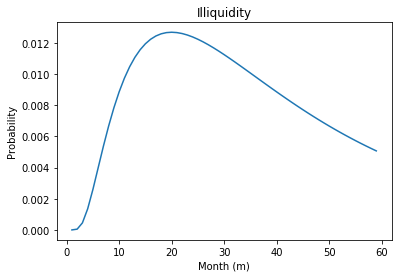

In [14]:
"""Calculate the probability of illiquidity
"""
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

month = range(44)

def prob_illiquid(m, const=2, drift=.1, variance=.16):
    expected_cash = const +  drift * m
    sigma = (variance * m)**0.5
    p_illiquid = norm.cdf( (0 - expected_cash) / sigma ,0,1)  # normalization
    return p_illiquid

print(f"Probability of illiquidity in 6 month : {prob_illiquid(6)*100:.4f}%")
print(f"Probability of illiquidity in 12 month: {prob_illiquid(12)*100:.4f}%")
print(f"Probability of illiquidity in 36 month: {prob_illiquid(36)*100:.4f}%")


X = range(1,12*5, 1)
fX = list(map(lambda m: prob_illiquid(m), X))

plt.title("Illiquidity")
plt.plot(X, fX)
plt.xlabel("Month (m)")
plt.ylabel("Probability")

plt.show()

### Geometric Brownian motion

A stochastic process $S$ follows a Geometric Brownian Motion (GBM) if it satisfies the following (SDE)

$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

where $W_t = W_t - W_0 \sim \mathcal{N}(0,t)$, i.e. a Wiener process, hence, normally distributed increments.

For an arbitrary initial value $S_0$, the above SDE has the following analytical solution (under Ito's interpretation)

$$S_t = S_0 \exp\left( \left(\mu - \frac{\sigma^2}{2}\right) t + \sigma W_t \right)$$

, hence,

$$\ln \frac{S_t}{S_0} = \left(\mu - \frac{\sigma^2}{2}\right) t + \sigma W_t$$

Note that $W_t = z \sqrt{t}$, where $z \sim \mathcal{N}(0,1)$. Therefore, $\ln \frac{S_t}{S_0}$ (log-return) is normally and $S_t$ is log-normally distributed.

E[S] tomorrow = 50.0219
Price vola    =  0.7851
With 95% confidence: 48.48 < S_1 < 51.56
1 day 95% VaR =  -1.31


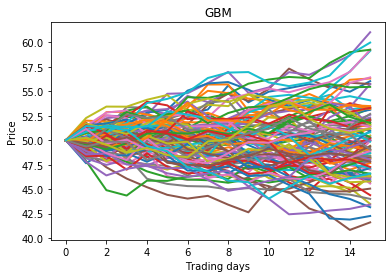

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

S_0 = 50
mu = 0.16
sigma = 0.3

# Expected price and price volatility
S_1 = 50*(1+mu/365)
print(f"E[S] tomorrow = {S_1:.4f}")
price_vola = 50*sigma*(1/365)**0.5
print(f"Price vola    =  {price_vola:.4f}")

# Confidence interval
q975 = norm.ppf(0.975, 0, 1)
print(f"With 95% confidence: {S_1 - price_vola * q975 :.2f} < S_1 < {S_1 + price_vola * q975 :.2f}")

# Value at risk
q95 = norm.ppf(0.95, 0, 1)
print(f"1 day 95% VaR =  {S_0 - (S_1 + price_vola * q95) :.2f}")

def gbm(mu, sigma, N=15):
    """Cumulative returns from a GBM
    """
    # Random numbers N(0,1)
    Z = np.random.normal(0, 1, N)
    # returns for our geometric brownian motion
    R = Z * sigma * np.sqrt(1/250) + (mu-0.5*sigma**2) * 1/250
    # stock process (insert 100 for t=0)
    S = np.insert(np.exp(np.cumsum(R)), 0, 1)
    return S

plt.title("GBM")
for n in range(100):
    plt.plot(S_0*gbm(mu, sigma), linewidth=2)
plt.xlabel("Trading days")
plt.ylabel("Price")
plt.show()

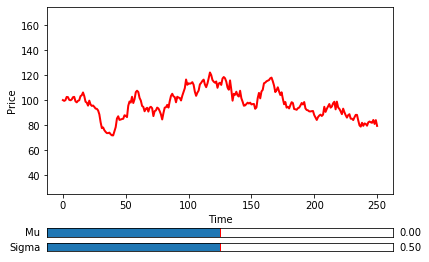

In [16]:
# Open gbm.py directly in the console to get a dynamic plot
import gbm

## Binomial option pricing models

Consider a replicating portfolio with bond (cash) $B$ and $\Delta$ share in the underlying asset $S$

$$
\begin{align}
V_0 &= B + \Delta S_0\\
V_u &= B e^{rt} + \Delta S_u = (S_u - K)^+\\
V_d &= B e^{rt} + \Delta S_d = (S_d - K)^+
\end{align}
$$

Note that

$$\Delta = \frac{(S_u - K)^+ - (S_d - K)^+}{S_u - S_d}$$

#### Example:
* Replication in a world with only two possible future states, i.e. price goes up $𝑆_𝑢=60$ and price goes down $𝑆_𝑑=40$.
* Consider a 1Y call option with a Strike of 45 on an asset that currently trades at 50 and a continuous risk free rate of 5%

$$
\begin{align}
V_u &= -28.54 e^{0.5} + 0.75 \times 60 = 15\\
V_d &= -28.54 e^{0.5} + 0.75 \times 40 = 0\\
&...\\
V_0 &= -28.54 + 0.75 \times 50 = 8.96\\
\end{align}
$$

In [17]:
"""Replicate the option payout in a one step lattice
"""
import numpy as np

def delta(flag, S_u, S_d, K):  # flag = 1 (Call); -1 (Put)
    delta = ( np.maximum(flag*(S_u - K), 0) - np.maximum(flag*(S_d - K), 0) ) / (S_u - S_d)
    return delta
#print(delta(1, 60, 40, 45))

def bond(flag, S_u, S_d, K, r, T):
    beta = (np.maximum(flag*(S_u - K), 0) - delta(flag, S_u, S_d, K) * S_u) * np.exp(-r*T)
    return beta
#print(beta(1, 60, 40, 45, 0.05, 1))

print(f"V_u = {bond(1, 60, 40, 45, 0.05, 1)*np.exp(.05)+delta(1, 60, 40, 45)*60:.0f}")
print(f"V_d = {bond(1, 60, 40, 45, 0.05, 1)*np.exp(.05)+delta(1, 60, 40, 45)*40:.0f}")
print(f"V_0 = {bond(1, 60, 40, 45, 0.05, 1)+delta(1, 60, 40, 45)*50:.4f}")

V_u = 15
V_d = -0
V_0 = 8.9631


### Coxx-Ross-Rubinstein (CRR)

The underlying of an option with maturity $T$ is modelled by an $n$ step binomial tree, with time between two steps of the tree $\Delta t = T / n$. With up move $u$ and down move $d$

$$u = \exp\left(\sigma \sqrt{\Delta t}\right)$$

$$d = u^{-1}$$

The following must hold for the up move probability $p$, in order to ensure martingale property,

$$S_0 = \left( S_0 \times u \times p + S_0 \times d \times (1-p) \right) e^{-r\Delta t} \implies p = \frac{e^{r\Delta t} - d}{u - d}$$

Remember the binomial probability mass function (PMF)

$$f(k,n,p) = {n \choose k} p^k (1-p)^{n-k}$$

here, $n$ is the number of steps in the tree and $k$ the number of up moves to reach a state $S_T$.

### European vs American options

The CRR model is solved recuresively by discounting expected values. For American options, the buyer has the right to exercise at any point in time. Due to its discrete modelling of time, the CRR model allows execution at any node in the lattice. However, the buyer would only execute if the value that can be realized through execution $IV_t$ (intrinsic value) is above the discounted expected value of the next node. Therefore, the value that is considered for each node is

$$V_t = \max\left(E[V_{t+\Delta t}]e^{-r\Delta t}, IV_t \right).$$

[[220.0], [110.02008068234205, 439.9196919310029], [55.02008251522298, 220.0, 879.6787970394022]]


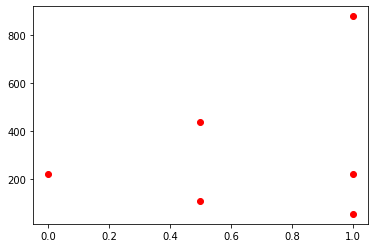

In [18]:
"""Replicating options, Cox Ross Rubinstein style
"""
import numpy as np
import matplotlib.pyplot as plt

# INPUTS
S_0   = 220  # price of the underlying
K     = 220  # strike price
sigma = .98  # volatility
rate  = np.log(1.21)  # converting the ISDA rate
T     = 1    # time to maturity
steps = 2    # steps

# see Slide 10
dt = T / steps
u = np.exp(sigma * np.sqrt(dt))
d = 1 / u

binomial_tree = []
for n in range(steps+1):
    binomial_tree.append([])
    for k in range(n+1):
        S_nk = S_0 * u**(k) * d**(n-k)
        binomial_tree[-1].append(S_nk)
        plt.plot(n*dt, S_nk, 'ro')  # this will take forever for large # steps
print(binomial_tree)
plt.show()

In [19]:
"""Full CRR model
"""
import matplotlib.pyplot as plt
import numpy as np

def Binomial(n, S, K, r, v, t, PutCall=1, American=False):  
    At = t/n 
    u = np.exp(v*np.sqrt(At))
    d = 1./u
    p = (np.exp(r*At)-d) / (u-d) 
    # Binomial price tree
    stockvalue = np.zeros((n+1,n+1))
    stockvalue[0,0] = S
    for i in range(1,n+1):
        stockvalue[i,0] = stockvalue[i-1,0]*u
        for j in range(1,i+1):
            stockvalue[i,j] = stockvalue[i-1,j-1]*d
    # option value at final node    
    optionvalue = np.zeros((n+1,n+1))
    for j in range(n+1):
        optionvalue[n,j] = max(0, PutCall*(stockvalue[n,j]-K))
    # recursive calculations   
    for i in range(n-1,-1,-1):
        for j in range(i+1):
            if American:
                optionvalue[i,j] = max(0, PutCall*(stockvalue[i,j]-K), np.exp(-r*At)*(p*optionvalue[i+1,j]+(1-p)*optionvalue[i+1,j+1]))
            else:
                optionvalue[i,j] = np.exp(-r*At)*(p*optionvalue[i+1,j]+(1-p)*optionvalue[i+1,j+1])
    return optionvalue[0,0]

# Inputs
S_0   = 220  # price of the underlying
K     = 220  # strike price (165 vs 220)
sigma = .98  # volatility
rate  = np.log(1 + 0.21)  # converting the ISDA rate
T     = 1    # time to maturity
steps = 2    # steps

#Graphs and results for the Option prices
print("European Call Price: %s" %(Binomial(steps, S_0, K, rate, sigma, T, PutCall=1)))
print("American Call Price: %s" %(Binomial(steps, S_0, K, rate, sigma, T, PutCall=1, American=True)))
print("European Put  Price: %s" %(Binomial(steps, S_0, K, rate, sigma, T, PutCall=-1)))
print("American Put  Price: %s" %(Binomial(steps, S_0, K, rate, sigma, T, PutCall=-1, American=True)))

European Call Price: 87.25679654189224
American Call Price: 87.25679654189224
European Put  Price: 49.07497836007403
American Put  Price: 59.982962882003555


In [20]:
from scipy.stats import binom

# Recall our CRR parameters
dt = T/steps 
u = np.exp(sigma*np.sqrt(dt))
d = 1./u
p = (np.exp(rate*dt)-d) / (u-d)

CoN_payout = []
AoN_payout = []
for n, S in enumerate(binomial_tree[-1]):  # This is the binomial tree that we generated above
    if S > 165:  # strike
        CoN_payout.append( binom.pmf(n, steps, p) * S * np.exp(-rate*T) )
        AoN_payout.append( binom.pmf(n, steps, p) * 165 * np.exp(-rate*T) )
CoN = sum(CoN_payout)
AoN = sum(AoN_payout)

print(f"Price cash or nothing  = {CoN:.2f}")
print(f"Price asset or nothing =  {AoN:.2f}")
print(f"CoN - AoN              = {CoN - AoN:.2f}")
print(f"CRR call price (above) = {Binomial(steps, S_0, 165, rate, sigma, T, PutCall=1):.2f}")

Price cash or nothing  = 203.63
Price asset or nothing =  87.28
CoN - AoN              = 116.35
CRR call price (above) = 116.35


## The Black-Scholes-Merton (BSM) model class


### Black Scholes (no dividend)

$$PV(Call) = S_0 N(d_+)− K e^{-rT} N(d_-)$$

$$PV(Put) = K e^{-rT} N(-d_-) − S_0 N(-d_+)$$

with

$$d_\pm = \frac{\ln\left(\frac{S_0}{K}\right) + rT \pm \sigma^2 \frac{T}{2}}{\sigma \sqrt{T}}$$


### Merton (incl. dividend)

$$PV(Call) = S_0 e^{-qT} N(d_+)− K e^{-rT} N(d_-)$$

$$PV(Put) = K e^{-rT} N(-d_-) − S_0 e^{-qT} N(-d_+)$$

with

$$d_\pm = \frac{\ln\left(\frac{S_0}{K}\right) + (r-q)T \pm \sigma^2 \frac{T}{2}}{\sigma \sqrt{T}}$$


### Black76 (forward)

$$PV(Call) = \left[F_T N(d_+)− K N(d_-)\right] e^{-rT}$$

$$PV(Put) = \left[K N(-d_-) − F_T N(-d_+) \right] e^{-rT}$$

with

$$d_\pm = \frac{\ln\left(\frac{F_T}{K}\right) \pm \sigma^2 \frac{T}{2}}{\sigma \sqrt{T}}$$

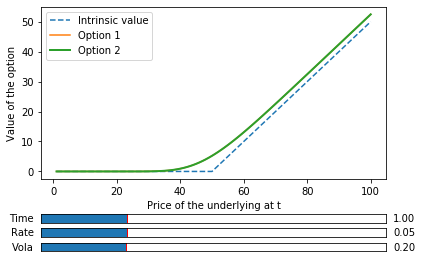

In [21]:
# Open callplot.py directly in the console to get a dynamic plot
import callplot

European Call Price: 95.91455141466928
European put  Price: 57.73273323285109


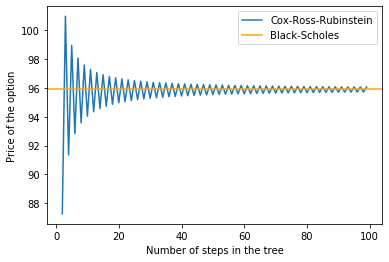

In [22]:
"""CRR vs Black Scholes
"""
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

#%% Black-Scholes formula
def black_scholes(cpflag,S,K,T,r,sigma):
    # cpflag in {1 for call, -1 for put}
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    price = cpflag * (S * norm.cdf(cpflag*d1, 0.0, 1.0) - K * np.exp(-r * T) * 
            norm.cdf(cpflag*d2, 0.0, 1.0))
    return price

print("European Call Price: %s" %(black_scholes(1,220,220,1,np.log(1.21),.98)))
print("European put  Price: %s" %(black_scholes(-1,220,220,1,np.log(1.21),.98)))

X = range(2,100, 1)
crr_prices = list(map(lambda n: Binomial(n, 220, 220, np.log(1.21), .98, 1, PutCall=1), X))

plt.plot(X,crr_prices)
plt.axhline(y=black_scholes(1,220,220,1,np.log(1.21),.98), color='orange')
plt.xlabel("Number of steps in the tree")
plt.ylabel("Price of the option")
plt.legend(["Cox-Ross-Rubinstein", "Black-Scholes"])
plt.show()

## Option pricing via Monte Carlo simulation

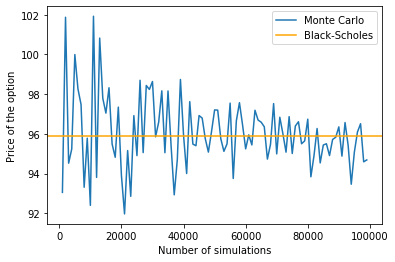

In [23]:
"""Monte Caro simulation vs Black Scholes
"""
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# See Chapter 2.4
def black_scholes(cpflag,S,K,T,r,sigma):
    # cpflag in {1 for call, -1 for put}
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    price = cpflag * (S * norm.cdf(cpflag*d1, 0.0, 1.0) - K * np.exp(-r * T) * 
            norm.cdf(cpflag*d2, 0.0, 1.0))
    return price

# See Chapter 2.2
def monte_carlo(cpflag,S,K,T,r,sigma,Nsim):
    Z = np.random.normal(0, 1, Nsim)
    S_T = S * np.exp(Z * sigma * np.sqrt(T) + (r-0.5*sigma**2) * T)
    CF_T = np.maximum(cpflag*(S_T - K),0)
    price = np.mean(CF_T) * np.exp(-r*T)
    return price

# Increase Nsim from 1000 to 100000 by 1000
X = range(1000,100000, 1000)
# Compute prices for all Nsim in X
mc_prices = list(map(lambda n: monte_carlo(1,220,220,1,np.log(1.21),0.98,n), X))

plt.plot(X,mc_prices)
plt.axhline(y=black_scholes(1,220,220,1,np.log(1.21),0.98), color='orange')
plt.xlabel("Number of simulations")
plt.ylabel("Price of the option")
plt.legend(["Monte Carlo", "Black-Scholes"])
plt.show()

## Option pricing via straightforward integration (BSM)

### European call option

The European call price is simply the discounted expected value of its payout $E^\mathbb{Q}[(S_T - K)^+] e^{-rT}$, with

$$\begin{align}
E^\mathbb{Q}[(S_T - K)^+] &= \int_K^\infty (S_T - K) f(S_T) dS_T\\
    &=\int_K^\infty S_T f(S_T) dS_T - K \int_K^\infty f(S_T) dS_T
\end{align}$$

The terminal stock price at time $T$, under the risk-neutral measure, follows a log-normal distribution with $\mu = \ln S_0 + (r_f-\sigma^2 / 2)T$, variance $s^2 = \sigma^2 T$ and PDF

$$f(x) = \frac{1}{x s \sqrt{2 \pi}} \exp\left( -\frac{(\ln x - \mu)^2}{2 s^2} \right) $$


### Binary options
#### Asset-or-nothing option

Consider a contract where you receive the underlying $S_T$ conditional on $S_T > K$, note that this is different from a call option where the cash flow is $S_T - K$ under the condition that $S_T > K$. The price of this (expensive) option is $E^\mathbb{Q}[S_T 1_{\{S_T > K\}}] e^{-rT}$, where

$$E^\mathbb{Q}[S_T 1_{\{S_T > K\}}] = \int_K^\infty S_T f(S_T) dS_T$$

#### Cash-or-nothing option

Now consider an option that pays some amount $K$ (cash) conditional on $S_T > K$. The price of this (again expensive) option is $K \times P^\mathbb{Q}[S_T > K] e^{-rT}$, where

$$P^\mathbb{Q}[S_T > K] = \int_K^\infty f(S_T) dS_T$$

Therefore, a European call option is a portfolio out of a long asset-or-noting option and a short cash-or-nothing option.

Black-Scholes price        : 95.91455141
AoN - CoN                  : 95.91455141
Straightforward integration: 95.91455141


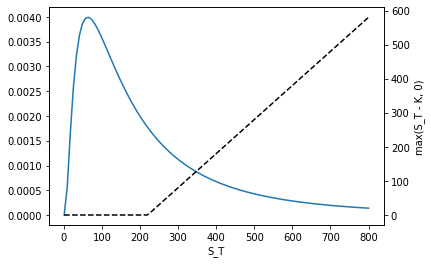

In [24]:
"""Straightforward integration vs Black Scholes
"""
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt

# See Chapter 2.4
def black_scholes(cpflag,S,K,T,r,sigma):
    # cpflag in {1 for call, -1 for put}
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    price = cpflag * (S * norm.cdf(cpflag*d1, 0.0, 1.0) - K * np.exp(-r * T) * 
            norm.cdf(cpflag*d2, 0.0, 1.0))
    return price

# probability density function P(S_T > K)
def PdF(S, S_0, rf, sd, t):
    A = 1 / ( np.sqrt(2*np.pi*t)*sd*S)
    B = np.exp(-(np.log(S)-(np.log(S_0)+(rf-0.5*sd**2)*t))**2/(2*sd**2*t))
    return A * B

# expected value S_T
def EdF(S, S_0, rf, sd, t):
    A = 1 / ( np.sqrt(2*np.pi*t)*sd*S)
    B = np.exp(-(np.log(S)-(np.log(S_0)+(rf-0.5*sd**2)*t))**2/(2*sd**2*t))
    return S * A * B

# expected value of (S_T - K)
def E2dF(S, S_0, rf, sd, t, K):
    A = 1 / ( np.sqrt(2*np.pi*t)*sd*S)
    B = np.exp(-(np.log(S)-(np.log(S_0)+(rf-0.5*sd**2)*t))**2/(2*sd**2*t))
    return (S - K) * A * B

# Inputs
S_0   = 220  # price of the underlying
K     = 220  # strike price
sigma = .98  # volatility
rate  = np.log(1.21)  # converting the ISDA rate
T     = 1    # time to maturity
steps = 2    # steps

# asset or nothin
AoN = quad(lambda x: EdF(x, S_0, rate, sigma, T), K, +np.inf)[0] * np.exp(-rate*T)
# cash or nothing with cash = K
CoN = K * quad(lambda x: PdF(x, S_0, rate, sigma, T), K, +np.inf)[0] * np.exp(-rate*T)
# straight forward integration
Call = quad(lambda x: E2dF(x, S_0, rate, sigma, T, K), K, +np.inf)[0] * np.exp(-rate*T)

print(f"Black-Scholes price        : {black_scholes(1,S_0,K,T,rate,sigma):.8f}")
print(f"AoN - CoN                  : {AoN-CoN:.8f}")
print(f"Straightforward integration: {Call:.8f}")

x = np.linspace(1, 800, 100)
fig, ax1 = plt.subplots()
ax1.plot(x, PdF(x, S_0, rate, sigma, T))
ax1.set_xlabel('S_T')
ax2 = ax1.twinx()
ax2.plot(x, np.maximum(x-K,0), '--', color="black")
ax2.set_ylabel('max(S_T - K, 0)')
plt.show()

## Implied volatility

All parameters that determine the option price in a BSM model are observable, except $\sigma$. However, option prices are not calculated, they are the result of supply and demand on a liquid market. Thus, given an option price, we can find the $\sigma$ that ceteris paribus equates the BSM price with the market price.

In [25]:
"""Calculate implied volatility
"""
# Inputs
S_0   = 220  # price of the underlying
K     = 220  # strike price
rate  = np.log(1.21)  # converting the ISDA rate
T     = 1    # time to maturity
steps = 2    # steps
P_MKT = 85   # market price of the option

def iv_solve(IV):
    P_BSM = black_scholes(1,S_0,K,T,rate,IV)
    return (P_BSM - P_MKT)**2
IV = minimize(iv_solve, x0=0.25, bounds = ((0, None),)).x[0]

print(f'Implied vol: {IV:.4f}')
print(f'BSM price  : {black_scholes(1,S_0,K,T,rate,IV):.4f}')

Implied vol: 0.8251
BSM price  : 85.0000


<a id='CreditDerivatives'></a>
# Credit derivatives

## Credit default swaps (CDS)
A CDS contract works like an insurence that is linked to a credit event. This is, the protection buyer pays a premium $S$ (CDS spread) to the protection seller until the contract matures in $T$. In case of a default during the term of the contract, i.e. default in $\tau < T$, the protection buyer receives a settlement payment from the seller. This settlement payment is often, but not necessarily, designed to cover the loss given the default of a credit risky position, i.e. $(1 - \mathrm{Recovery})$.

## Replication

The payout can be replicarted with one credit risky and another risk free floater, which both trade at par. Shorting the risky floater yields 100% nominal, which can be invested into the risk free floater. The latter pays per definition the risk free rate $r_f$, wheres payments into the risky floater include an additional (credit) spread $r_f + S_{FRN = Par}$. In case of a credit event, the risk free floater is sold at 100%, whereas the risky floater is bought back at recovery. As this replicates the payout of the CDS $(1 - \mathrm{Recovery})$, the replicating credit spread must be equal to the CDS spread $S$. However, this is only an approximation, as it ignores that recovery is only paid on the nominal amount, transaction costs, and liquidity differences (availability) of the floaters.

$$S_{FRN = Par} \approx S$$

If a floater is not trading at par, the replication does not work. However, the PV difference must be due to the discounted difference in spreads. Thus, given the spread $S_{FRN \neq Par}$ and price $P_{FRN\neq Par}$ of a non par floater, we can solve for the spread of the corresponding par floater $S_{FRN = Par}$

$$
\begin{align}
P_{FRN\neq Par} - 100\% &= PV(S_{FRN\neq Par} - S_{FRN = Par})\\
    &= (S_{FRN\neq Par} - S_{FRN = Par}) \sum_{t=1}^T DF_t\\
    &...\\
S_{FRN = Par} &= S_{FRN\neq Par} - \frac{P_{FRN \neq Par} - 100\%}{\sum_{t=1}^T DF_t}
\end{align}
$$

No floater available? No problem, use an asset swap to create a synthetic floater, which at par is worth

$$
\begin{align}
100\% &= P_\mathrm{Bond} - PV(C_\mathrm{Bond}) + PV(\mathrm{Libor} + S)\\\\
    &= P_\mathrm{Bond} - C_\mathrm{Bond} \sum_{t=1}^T DF_t + 1 - DF_T + S \sum_{t=1}^T DF_t\\\\
S &= \frac{DF_T + C_\mathrm{Bond} \sum_{t=1}^T DF_t - P_\mathrm{Bond}}{\sum_{t=1}^T DF_t}
\end{align}
$$

If the bond is trading at par, $S$ is simply

$$S = C_\mathrm{Bond} - \frac{1-DF_T}{\sum_{t=1}^T DF_t}\\\\$$

The asset swap spread is only an approximation for the CDS spread, as the CDS cash flow is not perfectly replicated (close out value of the swap) and there might be liquidity issues.

## Hazard rates

As always, the price of a financial product is the sum of its discounted (expected) cash flows. Accounting for credit risk simply means accounting for both, (risk free) interest rate and the probability of default.

Let $h_t$, the hazard rate (default intensity), be the probability to default in an infinitesimally short time interval $dt$.

$$h_t = \ln\left(\frac{1-p_{t-1}}{1-p_t} \right) \implies e^{h_t} = \frac{1-p_{t-1}}{1-p_t} \Longleftrightarrow p_t = 1 - \frac{1- p_{t-1}}{e^{h_t}}$$

Then $a_t(h_t)$ is the present value of a paymment of $1$ at time $t$ if $t < \tau$, hence, no default. Think of this as a discount factor ($DF_t$) that also accounts for the likelyhood of the asset being alive.

$$a_t(h_t) = e^{-(h_t+r_t)t}$$

On the other hand, $b_t(h_t)$ is the present value of a payment of 1 at time $t$ if $t-1 < \tau < t$, hence, default between $t-1$ and $t$.

$$b_t(h_t) = e^{-r_t t} \left( e^{-(h_t)t_{-1}} - e^{-(h_t)t} \right)$$

Summing up the risky discount factors $a_t(h_t)$ and $b_t(h_t)$

$$
\begin{align}
A_T &= \sum_{t=1}^T a_t\\
B_T &= \sum_{t=1}^T b_t
\end{align}
$$

Allows us to price a CDS with spread $S$ as

$$
\begin{align}
0 &= PV(1-\mathrm{Recovery}) - PV(S)\\
  &= B_T(1-\mathrm{Recovery}) - A_T S\\\\
S &= \frac{B_T(1-\mathrm{Recovery})}{A_T}
\end{align}
$$

Hint: compare this to the single curve swap pricing above.

In practise, in preparation for central counterparty clearing, spread payments into a CDS are fixed at, i.e. $S^* \in \{0.002,0.01,0.05,0.1\}$, see ISDA agreements. Also the recovery rate is fixed, e.g. to 40% for investment grade. Therefore, contracts are unfair when entered and require an upfont payment

$$\mathrm{Upfront} =  B_T(1-\mathrm{Recovery}) - A_T S^*$$

In [26]:
"""Fair spread and upfront payment
"""
import numpy as np

def CDS_AB(h, r, T):
    # assuming a constant hazard rate h
    A_T = 0
    B_T = 0
    for t in range(1, T+1):
        r_t = r[t-1] if isinstance(r, (list, np.ndarray)) else r
        
        A_T += np.exp(-(h + r_t)*t)
        B_T += np.exp(-r_t*t) * ( np.exp(-h*(t-1)) - np.exp(-h*t) )

    return (A_T, B_T)

# Example:
h = 0.0209224
R = 0.3

# Fair spread:
A_T, B_T = CDS_AB(h, np.log([1.0365, 1.0386]), 2)
S = B_T*(1 - R) / A_T
print(f"Fair CDS spread: {S:.4f}")

# Upfront payment (spread payment of 100 basis points = 0.01)
upfront = (B_T*(1 - R) - A_T * 0.01) *10**7
upfront_alt = (S - 0.01) * A_T *10**7

print(f"Upfront payment on 10mln nominal: {upfront:.4f}")
print(f"Upfront payment on 10mln nominal: {upfront_alt:.4f}")

Fair CDS spread: 0.0148
Upfront payment on 10mln nominal: 88025.0332
Upfront payment on 10mln nominal: 88025.0332


## Hazard rate calibration

Recall the CDS replication via floating rate notes, solve for $h$ in $A_T$ and $B_T$, using that $S_{FRN = Par} \approx S$

$$
\begin{align}
P_{FRN} - 100\% &= (S_{FRN} - S) A_T\\
    &= A_T S_{FRN} - B_T(1-\mathrm{Recovery})\\
\end{align}
$$

Note that

$$\frac{S}{1-\mathrm{Recovery}} = \frac{B_T}{A_T} \approx h$$

This approximation is often called "credit triangle".

In [27]:
"""Calibrate constant hazard rate to floater
"""
from scipy.optimize import minimize

r = 0.0917
T = 2
P_FRN = 1
S_FRN = 0.004
R = 0.2

def h_solve(h):
    A_T, B_T = CDS_AB(h, r, T)
    return (A_T*S_FRN - B_T*(1-R) + 1 - P_FRN)**2*100
h = minimize(h_solve, x0=0.0001, bounds = ((0, None),)).x[0]
A_T, B_T = CDS_AB(h, r, T)
S = B_T*(1 - R) / A_T

print(f'Calibrated hazard rate: {h:.6f}')
print(f'Credit triangle       : {S_FRN/(1-R):.6f}')  # this works because P_FRN = 100% !
print(f'Calibrated CDS spread : {S:.6f}')
print(f'With A_T={A_T:.4f} and B_T={B_T:.6f}')

Calibrated hazard rate: 0.004988
Credit triangle       : 0.005000
Calibrated CDS spread : 0.004000
With A_T=1.7320 and B_T=0.008660


# Thank you for your attention

https://github.com/cafawo/derivatives/graphs/contributors

In [29]:
# This will convert the notebook to a html file
import os
# Convert to html slides
os.system('jupyter nbconvert derivatives.ipynb --to html')

0